# House Prices: Advanced Regression Techniques

Попросите покупателя дома описать дом своей мечты, и он, вероятно, не начнет с высоты потолка подвала или близости к железной дороге восток-запад. Но набор данных этого соревнования доказывает, что гораздо более важна возможность торга, чем количество спален или белый забор.

С 79 объясняющими переменными, описывающими (почти) каждый аспект жилых домов в Эймсе, штат Айова, это соревнование заставляет вас предсказать окончательную цену каждого дома.

**Цель**
Ваша задача - прогнозировать цену продажи каждого дома. Для каждого идентификатора в наборе тестов необходимо прогнозировать значение переменной **SalePrice**.

**Метрика качества**
Представления оцениваются по среднеквадратичной ошибке (RMSE) между логарифмом прогнозируемого значения и логарифмом наблюдаемой цены продажи. (Ведение журналов означает, что ошибки в прогнозировании дорогих домов и дешевых домов будут одинаково влиять на результат.)

## Импорты

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

import seaborn as sns
sns.set(font_scale = 1.5)

import numpy as np
from catboost import Pool, CatBoostRegressor

from sklearn.metrics import mean_squared_error

from math import sqrt

from sklearn import ensemble, tree, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

## Чтение, предобработка и первичный анализ

### Обработка обучающей выборки

Прочитаем файл train

In [2]:
house = pd.read_csv('train.csv', index_col='Id')

In [3]:
house.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
house.shape

(1460, 80)

В файле train 1460 строк

Посмотрим информацию

In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

В некоторых столбцах наблюдается отсутствие некоторых значений

### Обработка тестовой выборки

In [6]:
house_test = pd.read_csv('test.csv', index_col='Id')
house_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
house_test.shape

(1459, 79)

### Анализ столбца цен

Посмотрим статистику по столбцу цен

In [8]:
house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Построим гистограмму распределения цены

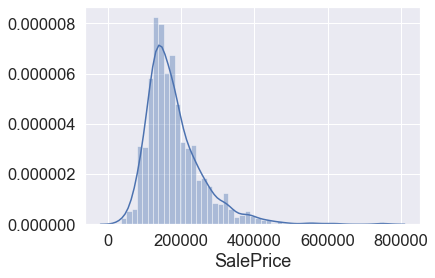

In [9]:
sns.distplot(house.SalePrice)

Распределение отличается от нормального

### Анализ корреляции признаков

Построим матрицу корреляции и выберем только более-менее коррелирующие признаки

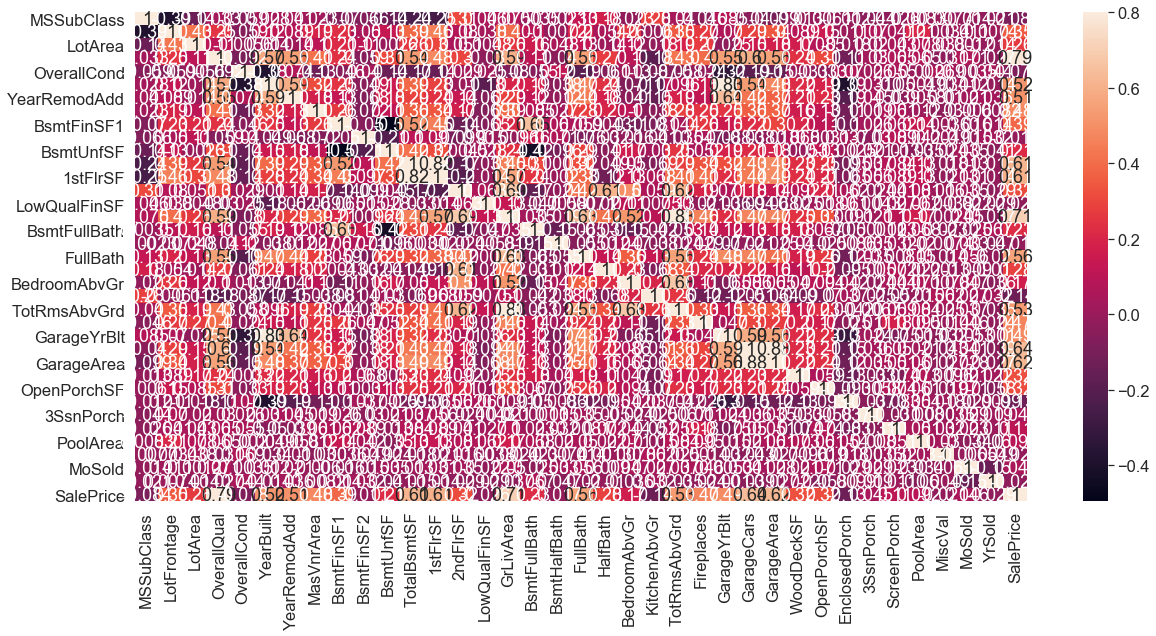

In [10]:
corrmat = house.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

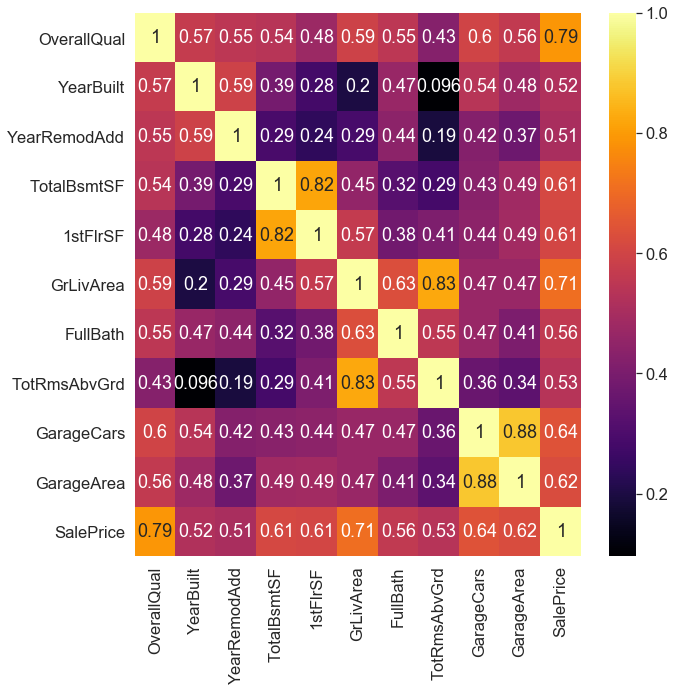

In [11]:
corrmat = house.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(house[top_corr_features].corr(),annot=True,cmap="inferno")


Видно, что с искомой переменной SalePrice хорошо коррелируют OverallQual(общее качество материалов и покрытия) и GrLivArea(расстояние над уровнем земли)

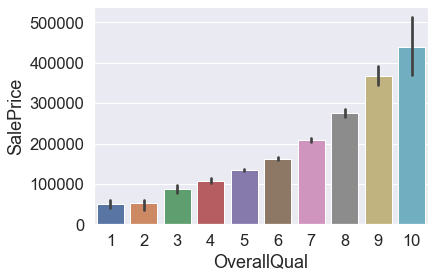

In [12]:
sns.barplot(house.OverallQual,house.SalePrice)

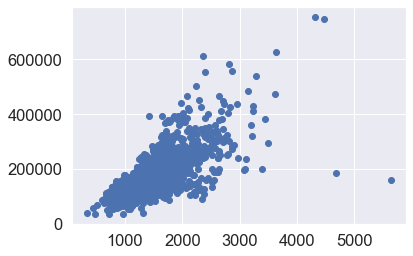

In [13]:
plt.scatter(house.GrLivArea, house.SalePrice)

В GrLivArea видны очевидные выбросы, от них можно избавиться

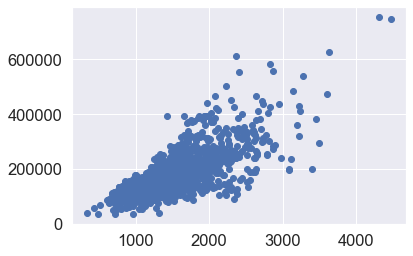

In [14]:
house = house[house.GrLivArea < 4500]
plt.scatter(house.GrLivArea, house.SalePrice)

In [15]:
house.shape

(1458, 80)

### Объединение двух датасетов для формирования обучающей выборки

In [16]:
features = pd.concat([house.drop(['SalePrice'], axis=1), house_test])#.reset_index(drop=True)
features.shape

(2917, 79)

Уберем самые некоррелирующие признаки

In [17]:
# итоговый результат ухудшается
#house = house.drop(['BsmtFinSF2','BsmtHalfBath','MiscVal','OverallCond','YrSold','LowQualFinSF'], axis=1)

### Разделение признаков

In [18]:
categorical_features = features.select_dtypes(include = ["object"]).columns
numerical_features = features.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
house_num = features[numerical_features]
house_cat = features[categorical_features]

Numerical features : 36
Categorical features : 43


#### Числовые признаки

In [19]:
house_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   LotFrontage    2431 non-null   float64
 2   LotArea        2917 non-null   int64  
 3   OverallQual    2917 non-null   int64  
 4   OverallCond    2917 non-null   int64  
 5   YearBuilt      2917 non-null   int64  
 6   YearRemodAdd   2917 non-null   int64  
 7   MasVnrArea     2894 non-null   float64
 8   BsmtFinSF1     2916 non-null   float64
 9   BsmtFinSF2     2916 non-null   float64
 10  BsmtUnfSF      2916 non-null   float64
 11  TotalBsmtSF    2916 non-null   float64
 12  1stFlrSF       2917 non-null   int64  
 13  2ndFlrSF       2917 non-null   int64  
 14  LowQualFinSF   2917 non-null   int64  
 15  GrLivArea      2917 non-null   int64  
 16  BsmtFullBath   2915 non-null   float64
 17  BsmtHalfBath   2915 non-null   float64
 18  FullBath

##### Нормировка числовых признаков

In [20]:
house_num = (house_num - house_num.mean()) / house_num.std()
house_num.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2.917000e+03,2.431000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.894000e+03,2.916000e+03,2.916000e+03,...,2.916000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03,2.917000e+03
mean,1.041334e-16,1.490649e-16,-1.071782e-16,1.814722e-16,-1.546776e-16,3.357235e-15,-4.119053e-15,1.227614e-18,6.822770e-17,2.436703e-18,...,-2.863127e-17,-4.140976e-17,4.019182e-17,-2.314075e-17,-1.461521e-17,-1.705108e-17,-9.743473e-18,-1.217934e-18,9.743473e-18,5.156489e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.731222e-01,-2.113951e+00,-1.132240e+00,-3.615821e+00,-4.099969e+00,-3.278238e+00,-1.639277e+00,-5.699032e-01,-9.883676e-01,-2.931386e-01,...,-2.201135e+00,-7.399625e-01,-7.044221e-01,-3.596783e-01,-1.033486e-01,-2.859924e-01,-6.043712e-02,-8.960755e-02,-1.921652e+00,-1.363111e+00
25%,-8.731222e-01,-4.466791e-01,-3.411588e-01,-7.722946e-01,-5.074159e-01,-6.038225e-01,-9.213079e-01,-5.699032e-01,-9.883676e-01,-2.931386e-01,...,-7.101335e-01,-7.399625e-01,-7.044221e-01,-3.596783e-01,-1.033486e-01,-2.859924e-01,-6.043712e-02,-8.960755e-02,-8.158933e-01,-6.028444e-01
50%,-1.677733e-01,-5.179882e-02,-8.805379e-02,-6.141314e-02,-5.074159e-01,5.652701e-02,4.189016e-01,-5.699032e-01,-1.598790e-01,-2.931386e-01,...,3.536718e-02,-7.399625e-01,-3.170502e-01,-3.596783e-01,-1.033486e-01,-2.859924e-01,-6.043712e-02,-8.960755e-02,-7.872101e-02,1.574224e-01
75%,3.024594e-01,4.747082e-01,1.814467e-01,6.494684e-01,3.907225e-01,9.810163e-01,9.454125e-01,3.488113e-01,6.618556e-01,-2.931386e-01,...,4.826676e-01,5.877581e-01,3.385022e-01,-3.596783e-01,-1.033486e-01,-2.859924e-01,-6.043712e-02,-8.960755e-02,6.584513e-01,9.176891e-01
max,3.123855e+00,1.069772e+01,2.627188e+01,2.782113e+00,3.085138e+00,1.278174e+00,1.232600e+00,8.393166e+00,8.039457e+00,8.722648e+00,...,4.732021e+00,1.051405e+01,1.035058e+01,1.538800e+01,2.005801e+01,9.962743e+00,2.308679e+01,2.986132e+01,2.132796e+00,1.677956e+00


##### Заполнение NaN-ов

В числовых признаках не так много NaN -ов, поэтому заполним их медианным значением, чтобы учесть влияние выбросов

In [21]:
# всего NaN-ов
house_num.isnull().values.sum()

678

In [22]:
house_num = house_num.fillna(house_num.median())

In [23]:
# осталось NaN-ов
house_num.isnull().values.sum()

0

#### Категориальные признаки

Обработка категориальных признаков

In [24]:
house_cat.shape

(2917, 43)

In [25]:
house_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2913 non-null   object
 1   Street         2917 non-null   object
 2   Alley          198 non-null    object
 3   LotShape       2917 non-null   object
 4   LandContour    2917 non-null   object
 5   Utilities      2915 non-null   object
 6   LotConfig      2917 non-null   object
 7   LandSlope      2917 non-null   object
 8   Neighborhood   2917 non-null   object
 9   Condition1     2917 non-null   object
 10  Condition2     2917 non-null   object
 11  BldgType       2917 non-null   object
 12  HouseStyle     2917 non-null   object
 13  RoofStyle      2917 non-null   object
 14  RoofMatl       2917 non-null   object
 15  Exterior1st    2916 non-null   object
 16  Exterior2nd    2916 non-null   object
 17  MasVnrType     2893 non-null   object
 18  ExterQual      2917 non-null

##### Заполнение NaN-ов

Посмотрим на значения этих признаков и подумаем, что значит NaN.
Заглянем в документацию к дата-сету

In [26]:
house_cat.Alley.fillna('NoAlley', inplace=True)
house_cat.BsmtQual.fillna('NoBsmt', inplace=True)
house_cat.BsmtCond.fillna('NoBsmt', inplace=True)
house_cat.BsmtExposure.fillna('NoBsmt', inplace=True)
house_cat.BsmtFinType1.fillna('NoBsmt', inplace=True)
house_cat.BsmtFinType2.fillna('NoBsmt', inplace=True)
house_cat.FireplaceQu.fillna('NoFire', inplace=True)
house_cat.GarageType.fillna('NoGar', inplace=True)
house_cat.GarageFinish.fillna('NoGar', inplace=True)
house_cat.GarageQual.fillna('NoGar', inplace=True)
house_cat.GarageCond.fillna('NoGar', inplace=True)
house_cat.PoolQC.fillna('NoPool', inplace=True)
house_cat.Fence.fillna('NoFnc', inplace=True)
house_cat.MiscFeature.fillna('NoFeat', inplace=True)

C:\Users\mi\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Остальные значение отсутствуют, заменим их на 0

In [27]:
house_cat = house_cat.fillna(0)

In [28]:
house_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NoPool,NoFnc,NoFeat,WD,Normal
2,RL,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NoPool,NoFnc,NoFeat,WD,Normal
3,RL,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NoPool,NoFnc,NoFeat,WD,Normal
4,RL,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NoPool,NoFnc,NoFeat,WD,Abnorml
5,RL,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NoPool,NoFnc,NoFeat,WD,Normal


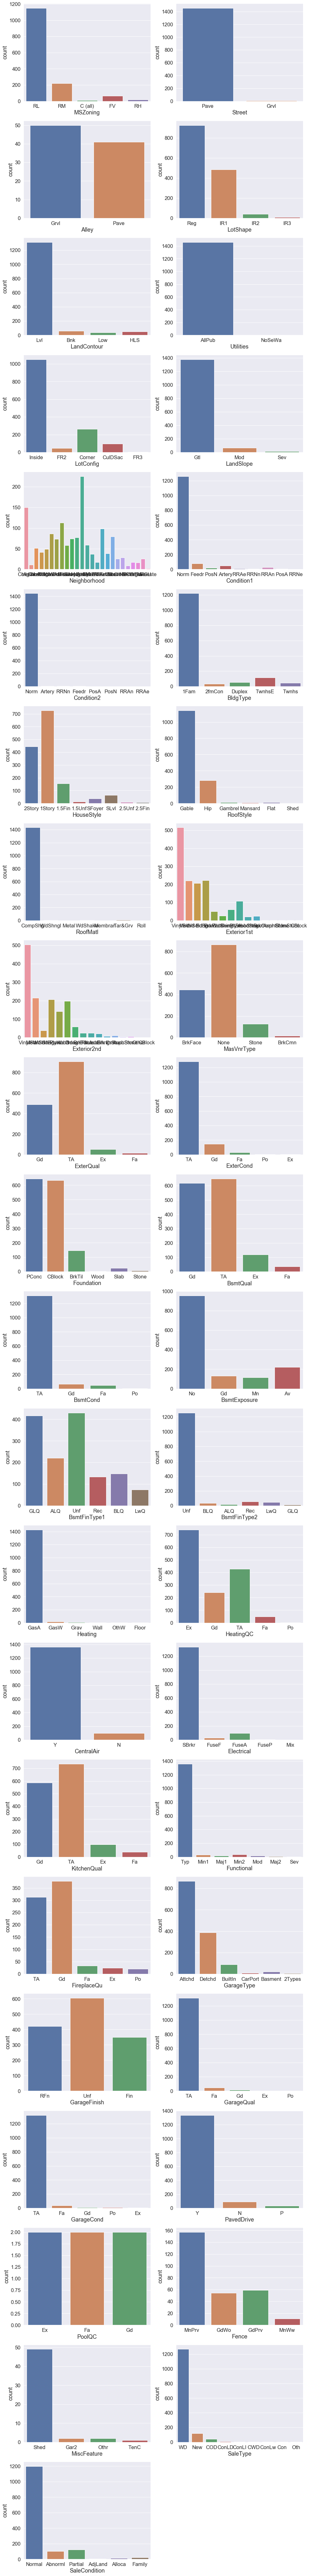

In [29]:
# lets check for the variance in the different continous numeric columns present in the dataset
plt.figure(figsize = (16,150))
for idx,col in enumerate(house_cat):
    plt.subplot(22,2,idx+1)
    sns.countplot(house[col]) #, hue=house['SalePrice'])

Переведем категориальные признаки в численный вид

In [30]:
#house_cat = house_cat.apply(lambda x: pd.factorize(x)[0])
#house_cat.shape

In [31]:
house_cat = pd.get_dummies(house_cat)
house_cat.shape

(2917, 274)

Объединим числовые и категориальные признаки обратно

In [32]:
house_features = pd.concat([house_num, house_cat], axis=1)
house_features.shape

(2917, 310)

### Oбратное разделение на test и train

In [33]:
features = house_features.iloc[:1458,:]
testing_features = house_features.iloc[1458:,:]

print(features.shape)
print(testing_features.shape)

(1458, 310)
(1459, 310)


In [34]:
testing_features.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,-0.873122,0.474708,0.189901,-0.772295,0.390723,-0.339683,-1.112766,-0.569903,0.065254,0.557630,...,0,0,0,1,0,0,0,0,1,0
1462,-0.873122,0.518584,0.528698,-0.061413,0.390723,-0.438735,-1.256360,0.035104,1.089608,-0.293139,...,0,0,0,1,0,0,0,0,1,0
1463,0.067343,0.211455,0.472722,-0.772295,-0.507416,0.848946,0.658225,-0.569903,0.792433,-0.293139,...,0,0,0,1,0,0,0,0,1,0


### Нормализация распределения таргета

Приведем распределение SalePrice к нормальному

In [35]:
house['SalePrice'] = np.log(house.SalePrice )

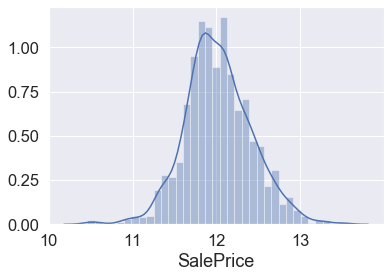

In [36]:
sns.distplot(house.SalePrice)

Данные готовы, теперь можно применять модели машинного обучения

## Применение алгоритмов машинного обучения

Подготовим обучающую выборку

In [37]:
X, y = features, house['SalePrice']


Разделим ее на тренировочную и валидационную

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.3, random_state=42)
print(X_train.shape, X_val.shape)

(437, 310) (1021, 310)


In [39]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

In [99]:
from sklearn.metrics import make_scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better= False, squared=False)
rmse_scorer

make_scorer(mean_squared_error, greater_is_better=False, squared=False)

### Линейная модель без регуляризации

Для начала попробуем использовать линейную модель

In [40]:
lr = LinearRegression(fit_intercept=True ,n_jobs=-1)

In [41]:
lr.fit(X_train,y_train)
test_pre = lr.predict(X_val)
train_pre = lr.predict(X_train)

Метрика RMSE для определения качества модели

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
print('RMSE on train =' , mean_squared_error(y_train, train_pre, squared=False))
print('RMSE on test =' , mean_squared_error(y_val, test_pre,squared=False))

RMSE on train = 0.059130528555766275
RMSE on test = 3162129783.759351


### Линейная модель с регуляризацией Elastic Net

In [101]:
from sklearn.linear_model import ElasticNetCV

In [106]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 1, 2, 10]
e_l1ratio = [.1, .5, .7, .9, .95, .99, 1]

elastic_cv = ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio)

elastic_model = elastic_cv.fit(X, y)

In [107]:
test_pre = elastic_model.predict(X_val)
train_pre = elastic_model.predict(X_train)

In [108]:
print('RMSE on train =' , mean_squared_error(y_train, train_pre, squared=False))
print('RMSE on test =' , mean_squared_error(y_val, test_pre,squared=False))

RMSE on train = 0.0917834507703957
RMSE on test = 0.10713514307256093


### Gradient boosting

In [86]:
model = XGBRegressor()

In [87]:
params = {
        'min_child_weight': [1, 3, 6],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'max_depth': [ 6, 8, 10],
        'n_estimators': [ 100, 150, 200],
        'learning_rate': [ 0.001, 0.01, 0.1, 0.2, 0.3],
        'colsample_bylevel' : [0.5, 0.7, 1],
        'colsample_bytree': [0.7, 1],
        'gamma':[0,1,5,10]
        }

In [88]:
clf = RandomizedSearchCV(model, params, n_jobs=-1, cv=5, verbose=3, refit=True, 
                         n_iter=10, scoring=rmse_scorer)
clf

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'colsample_bytree': [0.7, 1],
                                        'gamma': [0, 1, 5, 10],
                                        'learning_rate':

In [89]:
clf.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'colsample_bytree': [0.7, 1],
                                        'gamma': [0, 1, 5, 10],
                                        'learning_rate':

In [90]:
best_clf = clf.best_estimator_
best_clf

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5, tree_method=None,
             validate_parameters=False, verbosity=None)

In [91]:
y_pred_train = best_clf.predict(X_train)
y_pred = best_clf.predict(X_val)

In [92]:
print('RMSE on train =' , mean_squared_error(y_train, y_pred_train, squared=False))
print('RMSE on test =' , mean_squared_error(y_val, y_pred, squared=False))

RMSE on train = 0.09732161754002147
RMSE on test = 0.11806244335003045


## Получение ответов

In [93]:
X = testing_features

In [94]:
y = best_clf.predict(X)

In [95]:
Final_labels = np.exp(y)

Ансамбль двух моделей

In [97]:
# Дает худший результат
final_elastic = np.exp(elastic_model.predict(X))
final_xgb = np.exp(best_clf.predict(X))
Final_labels = (final_elastic+final_xgb)/2
Final_labels

array([119621.97266452, 152535.68443323, 177748.93981162, ...,
       171295.03243833, 117782.67079081, 231217.04501847])

## Сохранение результатов

In [98]:
pd.DataFrame({'Id': house_test.index, 'SalePrice': Final_labels}).to_csv('09_03_20.csv', index =False) 